In [76]:
import shapefile
from pyproj import Proj, transform
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
import sys
sys.path.append('../parsing')
import accessDB as db
%matplotlib inline

# data from https://city.milwaukee.gov/DownloadMapData3497.htm
# it is encoded in NAD27 in zone 4803 (Wisconsin South)

In [77]:
# open a single file
#f = open('ald2012.shp', 'rb')
#sf = shapefile.Reader(shp=f)

# load in maps
ald = shapefile.Reader('ald2016/alderman')
nbh = shapefile.Reader('hoods/neighborhood')
pol = shapefile.Reader('poldist/poldist')
ward = shapefile.Reader('wards/ward')
city = shapefile.Reader('corp/citylimit')

In [78]:
# converter for coordinates
inProj = Proj(init='EPSG:32054', preserve_units=True) # NAD27 Wisconsin South
outProj = Proj(proj='latlong', datum='WGS84', ellps='WGS84') # Latitude and Longitude

In [1]:
# read in a geolocated dataset
df = db.filter(nature='THEFT', doGeoLoc=True)
df.head()

NameError: name 'db' is not defined

In [80]:
# parse the latitude and longitude of the coordinates column
#split = df['Coordinates'].str.split(',', 1, expand=True)
#df['lat'] = split[0].str.replace('{\'lat\': ', '').astype(float)
#df['long'] = split[1].str.replace('\'lng\': ', '')
#df['long'] = df['long'].str.replace('}', '').astype(float)

In [81]:
# create a new dataframe with just the coordinates
coords = df[['Latitude', 'Longitude']]
coords = coords.dropna()
# some empty are missed I guess
coords = coords[coords['Latitude'] != '']
coords = coords[coords['Longitude'] != '']
coords.head()

,Latitude,Longitude
ID,,
182551367-Service in Progress,43.1396,-88.0092
182551467-Service in Progress,43.0542,-87.9417
182551704-City Citation(s) Issued,43.1096,-87.9683
182551704-Service in Progress,43.1096,-87.9683
182551945-Service in Progress,43.142,-87.9578


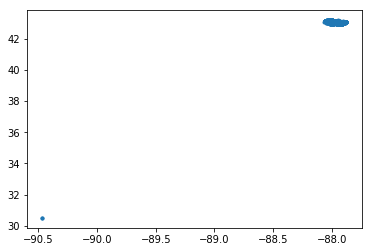

In [82]:
# just plot the points to confirms they're there
plt.plot(coords['Longitude'], coords['Latitude'], '.')

In [83]:
def plotOn(sf, coords, sfName, drawMap=False):
    # initialize plot size
    plt.figure(figsize=(10,18)) # approx dimensions of MKE is 5:9
    if not drawMap:
        # limit bounds of the plot
        plt.xlim(-88.1,-87.85)
        plt.ylim(42.9,43.2)
        m = plt
    else:
        # attempt to draw a map, it's not working
        m = Basemap(llcrnrlon=-88.1, llcrnrlat=42.9, urcrnrlon=-87.85, urcrnrlat=43.2, 
                    lon_0=(-88.1 + -87.85)/2, lat_0=(42.9 + 43.2)/2, 
                    resolution='i', projection='tmerc')
        m.drawcoastlines()
        m.drawrivers()
        m.drawmapboundary()
        m.fillcontinents(color='#ddaa66',lake_color='aqua')

    # loop through shapes
    polys = []
    for i,shape in enumerate(sf.shapes()):
        xs = []
        ys = []
        points = []

        # loop through points
        for point in shape.points:
            # parse points
            coord = [float('%.3f' % coord) for coord in point]
            # convert points
            x, y = transform(inProj, outProj, coord[0], coord[1])
            # add to list
            xs.append(x)
            ys.append(y)
            points.append((x, y))
            
        # make a polygon out of the points
        poly = Polygon(points)
        polys.append(poly)
        
        # find the district, ward, etc that a point is in
        for index, row in coords.iterrows():
            point = Point(row['Longitude'], row['Latitude'])
            if poly.contains(point):
                coords.loc[index, sfName] = i

        # plot shape
        m.plot(xs, ys, '-')

    #for index, row in coords.iterrows():
    m.plot(coords['Longitude'], coords['Latitude'], '.')

    plt.show()
    return polys

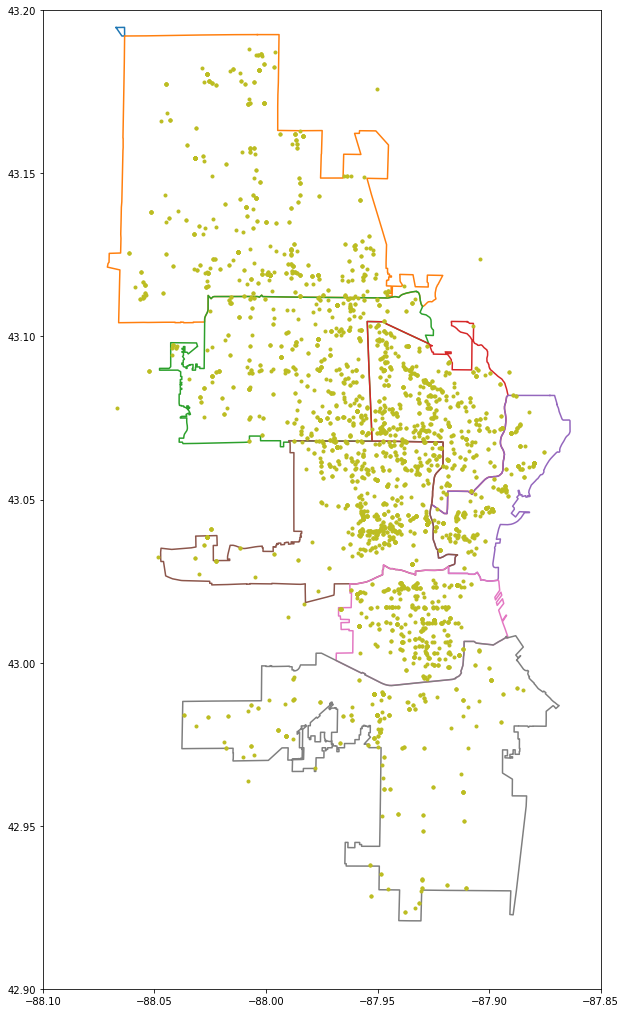

In [84]:
polys = plotOn(pol, coords, 'Police District')


In [85]:
coords.head()

,Latitude,Longitude,Police District
ID,,,
182551367-Service in Progress,43.1396,-88.0092,1.0
182551467-Service in Progress,43.0542,-87.9417,5.0
182551704-City Citation(s) Issued,43.1096,-87.9683,2.0
182551704-Service in Progress,43.1096,-87.9683,2.0
182551945-Service in Progress,43.142,-87.9578,1.0


                                       Latitude Longitude  Police District
ID                                                                        
182551367-Service in Progress           43.1396  -88.0092              1.0
182551467-Service in Progress           43.0542  -87.9417              5.0
182551704-City Citation(s) Issued       43.1096  -87.9683              2.0
182551704-Service in Progress           43.1096  -87.9683              2.0
182551945-Service in Progress            43.142  -87.9578              1.0
182552361-Service in Progress           43.0228  -87.9368              6.0
182552361-Unable to Locate Complainant  43.0228  -87.9368              6.0
182552487-Assignment Completed          43.1352  -88.0002              1.0
182552487-Referral                      43.1352  -88.0002              1.0
182552564-Unable to Locate Complainant  43.0216  -87.9577              6.0
182552725-Advised                        43.005  -87.9301              6.0
182552725-Service in Prog

5.0    752
6.0    660
2.0    570
3.0    548
1.0    517
4.0    262
7.0    248
Name: Police District, dtype: int64